In [ ]:
#!pip install geopandas
#!pip install sentinelsat
#!pip install rasterio
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 


In [75]:
import folium
import geopandas as gpd
from sentinelsat.sentinel import SentinelAPI
import rasterio 
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
from osgeo import gdal
import earthpy as et
import os
import pandas as pd

# New Section

In [ ]:
roi = gpd.read_file('../data/roi_gdlj.geojson')
print(roi.head())

In [ ]:
footprint = None
for i in roi['geometry']:
    footprint = i
    
user = 'davidmacer'
password = 'wFwKeDESv@TCuK8'
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
products = api.query(footprint,
                     date = ('20220701', '20220722'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 10))

In [ ]:
gdf = api.to_geodataframe(products)
gdf_sorted = gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
gdf_sorted

In [ ]:
gdf_sorted.iloc[0]['uuid']

In [ ]:
api.download(gdf_sorted.iloc[0]['uuid'])

In [ ]:
# Código para

In [ ]:
bands = r'./S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.SAFE/GRANULE/L2A_T13QFC_A028066_20220721T173238/IMG_DATA/R10m'

In [ ]:
os.listdir(bands)

FileNotFoundError: ignored

In [ ]:
blue = rasterio.open('./T13QFC_20220721T171859_B02_10m.jp2') 
green = rasterio.open('./T13QFC_20220721T171859_B03_10m.jp2') 
red = rasterio.open('./T13QFC_20220721T171859_B04_10m.jp2')
nir = rasterio.open('./T13QFC_20220721T171859_B08_10m.jp2')

In [ ]:
blue.read()

array([[[1439, 1493, 1526, ..., 1430, 1410, 1439],
        [1596, 1675, 1950, ..., 1439, 1412, 1437],
        [1768, 1906, 2016, ..., 1464, 1471, 1458],
        ...,
        [1809, 1778, 1728, ..., 1398, 1360, 1380],
        [1586, 1485, 1462, ..., 1401, 1356, 1376],
        [1470, 1640, 1750, ..., 1493, 1378, 1291]]], dtype=uint16)

# Recorte usando los bosques urbanos

In [68]:
#avi = (nir.read(1).astype(int)*(1-red.read(1))*(nir.read(1)-red.read(1)))
savi = (nir.read(1).astype(int)-red.read(1).astype(int))/(nir.read(1).astype(int)+red.read(1).astype(int) + 1) * (1+1)
ndvi = (nir.read().astype(int)-red.read().astype(int))/(nir.read().astype(int)+red.read().astype(int))

In [69]:
print(savi.min()), print(savi.max())
print(ndvi.min()), print(ndvi.max())
print(ndvi[0].shape)

-1.3843790266627019
1.5923340177960301
-0.6922238192000792
0.7962760131434831
(10980, 10980)


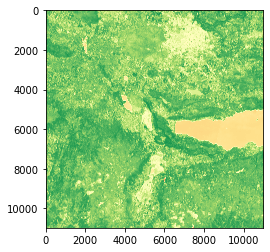

In [11]:
plt.imshow(ndvi[0], cmap='RdYlGn')

0.0
1.0
(10980, 10980)


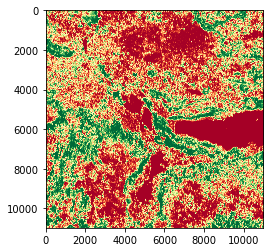

In [33]:
ndvi[0][ndvi[0] >= 0.5] = 1
ndvi[0][ndvi[0] < 0.5] = 0
print(ndvi.min()), print(ndvi.max()), print(ndvi[0].shape)
plt.imshow(ndvi[0], cmap='RdYlGn')

In [34]:
def array_to_raster(raster_array, raster_orig, path_to_save = "./output.tif"):
  import numpy as np
  import rasterio
  from rasterio.crs import CRS
  from rasterio.transform import from_origin

  # Add One Dimension(dst.write needs three dimentions)
  raster_array = np.array([raster_array])

  # Get Some Parameters
  dim = raster_array.shape
  height = dim[1]
  width = dim[2]
  dtype = raster_array.dtype

  # Get EPSG code
  epsg = raster_orig.crs.to_epsg()
  crs = CRS.from_epsg(epsg)

  # Get Sizes
  t = raster_orig.transform
  x_size = t[0]
  y_size = -t[4]

  # Get Upper Left Coordinates
  x_westup, y_westup = blue.xy(0,0)

  # Affine Transformation
  transform = from_origin(west = x_westup-5, north = y_westup+5, xsize = x_size, ysize = y_size)

  # Save Raster
  with rasterio.open(path_to_save, "w",
                   driver = "GTiff",
                   height = height,
                   width = width,
                   count = 1,
                   dtype = dtype,
                   crs = crs,
                   transform = transform) as dst:
    dst.write(raster_array)
  
  # Load Raster
  raster_loaded = rasterio.open("./output.tif")
  
  return raster_loaded

In [52]:
raster_load = array_to_raster(ndvi[0], blue)
print(raster_load.read().min()), print(raster_load.read().max())

0.0
1.0


(None, None)

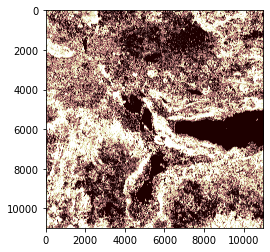

In [37]:
plt.imshow(raster_load.read(1), cmap='pink')

## Recorte de bosques urbanos
Vamos a recortar las zonas dentro de los bosques urbanos usando sus polígonos

In [97]:
bosques = gpd.read_file('./bosques_urbanos_jalisco.geojson')
bosques = bosques.to_crs(32613)

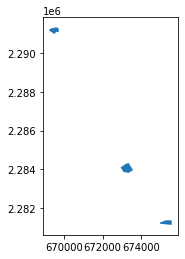

In [98]:
bosques.plot()

In [101]:
bosque_gallo = bosques.cx[670000:675000,2282000:2300000]
bosque_avila = bosques.cx[600000:670000,2290000:2500000]
bosque_tlaque = bosques


,id,nombre,desc,area_ha,geometry
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271..."


In [55]:

"""Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [102]:
coords_tlaque = getFeatures(bosque_tlaque)
coords_gallo = getFeatures(bosque_gallo)
coords_avila = getFeatures(bosque_avila)

In [103]:
out_img_tlaque, out_transform = mask(dataset=raster_load, shapes=coords_tlaque, crop=True)
out_img_gallo, out_transform = mask(dataset=raster_load, shapes=coords_gallo, crop=True)
out_img_avila, out_transform = mask(dataset=raster_load, shapes=coords_avila, crop=True)

In [62]:
out_img_tlaque[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

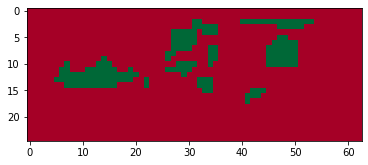

In [63]:
plt.imshow(out_img_tlaque[0], cmap='RdYlGn')

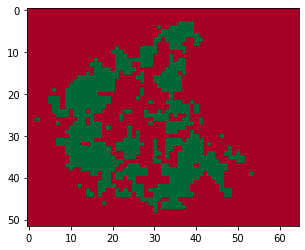

In [104]:
plt.imshow(out_img_gallo[0], cmap='RdYlGn')

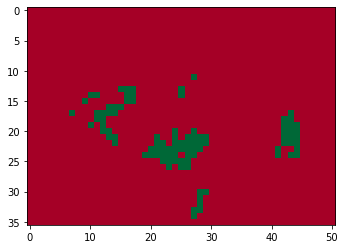

In [106]:
plt.imshow(out_img_avila[0], cmap='RdYlGn')

In [77]:
bosques_df = pd.DataFrame(bosques, copy=True)
bosques_df

,id,nombre,desc,area_ha,geometry
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951..."
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203..."
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271..."


In [108]:
area_tlaque = out_img_tlaque[0].mean()
area_gallo = out_img_gallo[0].mean()
area_avila = out_img_avila[0].mean()
area = [area_tlaque, area_gallo, area_avila]
area

[0.10793650793650794, 0.2150887573964497, 0.05337690631808279]

In [109]:
bosques_df["area_copa"] = area
bosques_df

,id,nombre,desc,area_ha,geometry,area_copa
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377


In [110]:
bosques = gpd.GeoDataFrame(bosques_df, copy=True)
bosques

,id,nombre,desc,area_ha,geometry,area_copa
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377


In [111]:
bosques = {"gonzalez_gallo": {"area": 17.29,
                             "estimador": 161},
          "tlaquepaque": {"area": 10,
                         "estimador": 161},
          "avila_camacho": {"area": 6,
                           "estimador": 161}}

def acervos_co2e(bosque_seleccionado: str, cobertura_copa: float) -> float:
    C = round(cobertura_copa, 3) # La documentación dice un decimal 17.3%
    A = bosques[bosque_seleccionado]["area"] 
    RE = bosques[bosque_seleccionado]["estimador"] 
    acervo_estimado = A*C*RE
    
    return acervo_estimado

# tCO2e
co2e_tlaque = acervos_co2e(bosque_seleccionado = "tlaquepaque", cobertura_copa = area_tlaque)
co2e_avila = acervos_co2e(bosque_seleccionado = "avila_camacho", cobertura_copa = area_avila)
co2e_gallo = acervos_co2e(bosque_seleccionado = "gonzalez_gallo", cobertura_copa = area_gallo)

print("tC02e para Tlaque:", co2e_tlaque)
print("tC02e para Avila:", co2e_avila)
print("tC02e para Gallo:", co2e_gallo)

tC02e para Tlaque: 173.88000000000002
tC02e para Avila: 51.198
tC02e para Gallo: 598.49335


In [112]:
acervo_co2 = [co2e_tlaque, co2e_gallo, co2e_avila]
bosques_df["acervo_co2"] = acervo_co2
bosques_df

,id,nombre,desc,area_ha,geometry,area_copa,acervo_co2
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937,173.88000
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089,598.49335
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377,51.19800


In [113]:
bosques = gpd.GeoDataFrame(bosques_df, copy=True)
bosques

,id,nombre,desc,area_ha,geometry,area_copa,acervo_co2
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937,173.88000
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089,598.49335
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377,51.19800


In [114]:
bosques.to_file("bosques_urbanos.geojson", driver='GeoJSON')

In [116]:
bosques.to_file("bosques_urbanos.gpkg", layer='bosques', driver="GPKG")